# Newtrinos.jl

**Newtrinos.jl** is a Julia package for the **global analysis of neutrino data**.

## Overview

The package is built to support flexible and modular analysis of neutrino physics, combining experimental data with theoretical models and inference tools.

## Code Structure

Newtrinos.jl is organized into three core components:

- **Experimental Likelihoods** (`src/experiments`):  
  Modules for various neutrino experiments and datasets, each encapsulating experiment-specific behavior.

- **Physics Modules** (`src/physics`):  
  Functions and tools for computing neutrino oscillation probabilities, atmospheric fluxes, and other theoretical predictions.

- **Analysis Tools** (`src/analysis`):  
  Interfaces for running inference — both **Frequentist** and **Bayesian** — using experimental and theoretical models.

## Design Philosophy

The codebase follows a **modular** and **orthogonal** architecture:

- **Experiments** only depend on their specific setup and data; they do **not** contain any theory or inference logic.
- **Physics** modules focus solely on theoretical modeling; they are unaware of experiments or statistical methods.
- **Inference** tools treat experiments and theory modules as interchangeable black boxes — allowing flexible composition.

This separation is enforced through consistent interfaces and data structures.

## Module Conventions

To ensure interoperability, each module (experimental or theoretical) should follow these conventions:

- Define all model parameters and priors using **`NamedTuple`s**.
- Experimental modules should implement the following functions:

  ```julia
  configure(config::NamedTuple)     # Configure the experiment with physics modules
  setup()                            # Initialize experiment internals
  get_forward_model()               # Return a callable model for likelihood evaluation
  plot(params::NamedTuple)          # (Optional) Visualize data or model output
  ```

Here, `config` is a `NamedTuple` containing any required physics module dependencies.

## Example Lieklihood

This section shows an example how to set up a joint likelihood.

In [36]:
using Newtrinos

Here we choose four experimental likelihoods:

In [12]:
exp_modules = (;Newtrinos.deepcore, Newtrinos.minos, Newtrinos.dayabay, Newtrinos.kamland)

(deepcore = Newtrinos.deepcore, minos = Newtrinos.minos, dayabay = Newtrinos.dayabay, kamland = Newtrinos.kamland)

Then we specify three physics modules in our config, where we decided on a module for standard 3-flavour oscillations, and modules for computing atmospheric fluxes and Earth density profiles:

In [13]:
config = (
    osc = Newtrinos.osc.standard,
    atm_flux = Newtrinos.atm_flux,
    earth_layers = Newtrinos.earth_layers
)

(osc = Newtrinos.osc.standard, atm_flux = Newtrinos.atm_flux, earth_layers = Newtrinos.earth_layers)

The experimental likelihoods now need to be configured with the physics. here we use the same config for all modules, and each module grabs whatever it needs from that config.

In [32]:
[m.configure(;config...) for m in exp_modules];

Then the setup function should be called once for each module, which will cause the module to load its data into `module.assets`

In [33]:
[m.setup() for m in exp_modules];

[ Info: Loading deepcore data
[ Info: Loading minos data
[ Info: Loading dayabay data
[ Info: Loading kamland data


This is enough to generate a joint likelihood for everything:

In [16]:
likelihood = Newtrinos.generate_likelihood(exp_modules);

Let's evaluate the likelihood! For this we also need parameter values. The following function goeas through both. experimental and theory modules and collects all parameters:

In [17]:
p = Newtrinos.get_params(exp_modules)

(atm_flux_delta_spectral_index = 0.0, atm_flux_nuenumu_sigma = 0.0, atm_flux_nunubar_sigma = 0.0, atm_flux_uphorizonzal_sigma = 0.0, deepcore_atm_muon_scale = 1.0, deepcore_ice_absorption = 1.0, deepcore_ice_scattering = 1.0, deepcore_lifetime = 2.5, deepcore_opt_eff_headon = 0.0, deepcore_opt_eff_lateral = 0.0, deepcore_opt_eff_overall = 1.0, kamland_energy_scale = 0.0, kamland_flux_scale = 0.0, kamland_geonu_scale = 0.0, nc_norm = 1.0, nutau_cc_norm = 1.0, Δm²₂₁ = 7.53e-5, Δm²₃₁ = 0.0024752999999999997, δCP = 1.0, θ₁₂ = 0.5872523687443223, θ₁₃ = 0.1454258194533693, θ₂₃ = 0.8556288707523761)

In [18]:
using DensityInterface

In [20]:
@time logdensityof(likelihood, p)

  0.042326 seconds (49.10 k allocations: 76.227 MiB, 17.94% gc time)


-1080.6543117055216

If the likelihood defines a plotting function, we can make convenient plots:

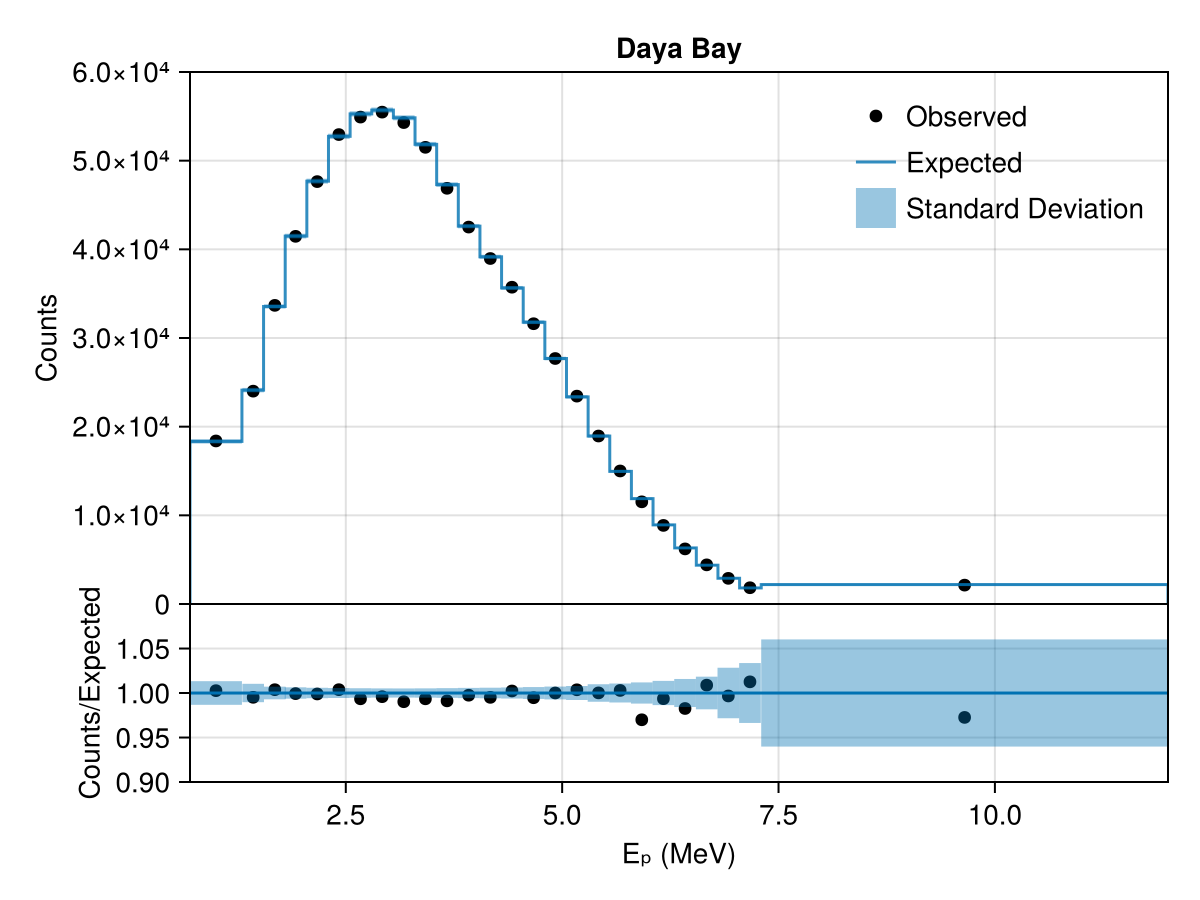

In [35]:
img = exp_modules.dayabay.plot(p)
display("image/png", img)

## Automatic Differentiation

For efficient inference, it is important to have access to gradients. therefore all code is fully differentiable via auto-diff, using the ForwardDiff package:

In [37]:
using ForwardDiff

In [38]:
ForwardDiff.gradient(p -> logdensityof(likelihood, p), p)

(atm_flux_delta_spectral_index = 262.8120902081794, atm_flux_nuenumu_sigma = -0.6494110485544047, atm_flux_nunubar_sigma = -3.7454697695197274, atm_flux_uphorizonzal_sigma = 1.5904384931010436, deepcore_atm_muon_scale = -1.1612509099067818, deepcore_ice_absorption = 23.215534562299336, deepcore_ice_scattering = 309.74179980457177, deepcore_lifetime = -191.94268496042022, deepcore_opt_eff_headon = -33.947486872831675, deepcore_opt_eff_lateral = 40.41140595498514, deepcore_opt_eff_overall = -257.1048344886879, kamland_energy_scale = -1.3322233658320863, kamland_flux_scale = 1.1102273782788554, kamland_geonu_scale = 1.3338116809640645, nc_norm = -25.46398416438826, nutau_cc_norm = -59.46669650099511, Δm²₂₁ = 687419.0875551306, Δm²₃₁ = 15034.795584326293, δCP = -0.35888949190589636, θ₁₂ = -19.102454876163787, θ₁₃ = 420.73886060499507, θ₂₃ = -170.30277734032427)

## Inference

Let's run a likelihood analysis to construct confidence contours in the (θ₂₃, Δm²₃₁) parameter space.
Here we use a conditional likelihood for illusatration. More realistically, you may want to run `Newtrinos.profile` instead for a full profile likelihood.
Examples on Bayesian Inference will follow.

In [39]:
result = Newtrinos.scan(likelihood, Newtrinos.get_priors(exp_modules), (θ₂₃=31, Δm²₃₁=31), p)

NewtrinosResult((θ₂₃ = [0.5235987755982988, 0.5410520681182421, 0.5585053606381853, 0.5759586531581287, 0.593411945678072, 0.6108652381980153, 0.6283185307179586, 0.6457718232379018, 0.6632251157578452, 0.6806784082777885  …  0.890117918517108, 0.9075712110370513, 0.9250245035569946, 0.9424777960769379, 0.9599310885968813, 0.9773843811168245, 0.9948376736367678, 1.012290966156711, 1.0297442586766543, 1.0471975511965976], Δm²₃₁ = [0.002, 0.002033333333333333, 0.0020666666666666667, 0.0021, 0.0021333333333333334, 0.0021666666666666666, 0.0022, 0.0022333333333333333, 0.002266666666666667, 0.0023  …  0.0027, 0.0027333333333333333, 0.002766666666666667, 0.0028, 0.0028333333333333335, 0.0028666666666666667, 0.0029000000000000002, 0.0029333333333333334, 0.002966666666666667, 0.003]), (atm_flux_delta_spectral_index = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], atm_flux_nuenumu_sigma = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 

In [40]:
using CairoMakie

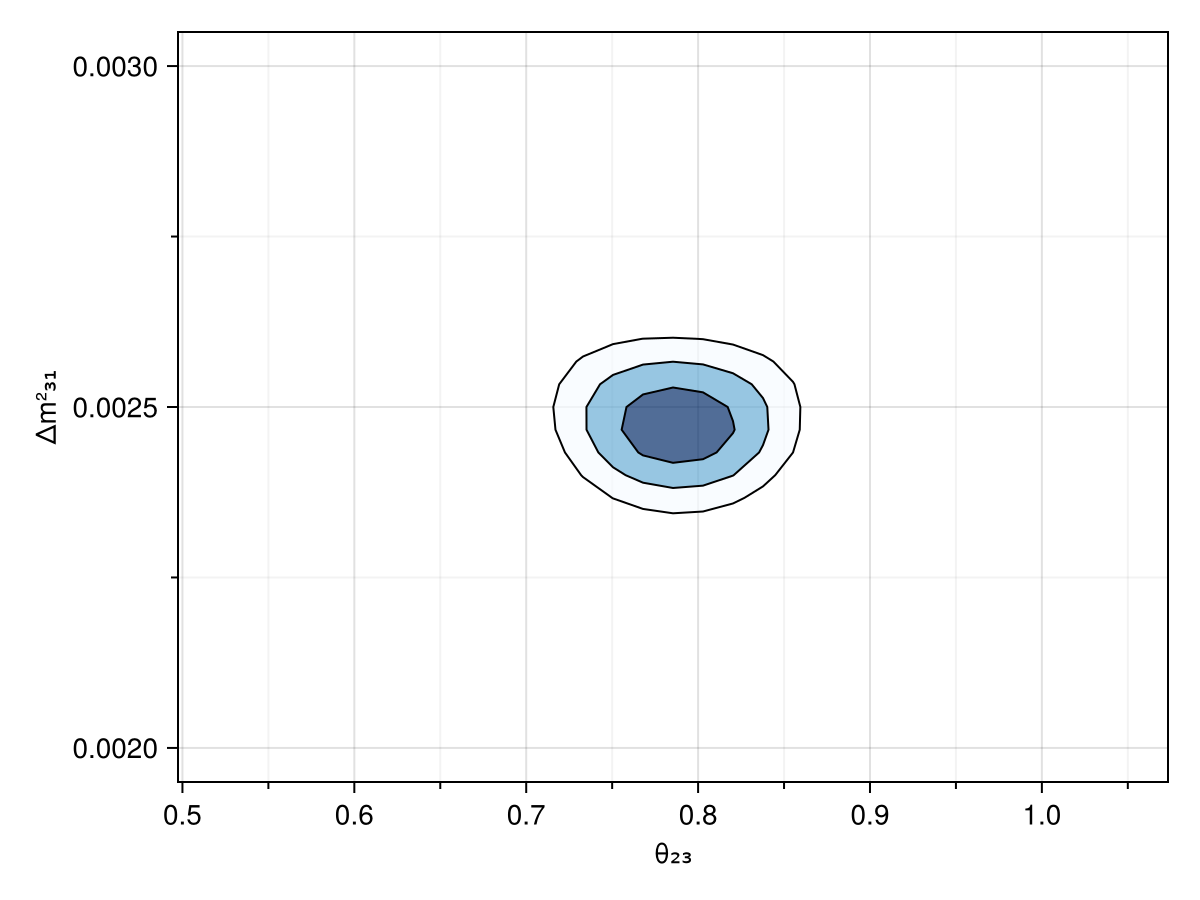

In [41]:
img = plot(result)
display("image/png", img)